# 📊 NFL Combine & Draft Analytics
### Predicting NFL Success from Combine Metrics
This notebook explores the relationship between NFL Combine performance and career success.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from bs4 import BeautifulSoup
import glob
import re

## 📂 Load Dataset
We'll load a dataset containing NFL Combine stats taken from [ProFootball Reference](https://www.pro-football-reference.com/draft/2024-combine.htm) from 2000-2024.

In [ ]:
# Define the path where your CSV files are stored
csv_path = 'data/*.csv'

# Get a list of all CSV files
all_csvs = glob.glob(csv_path)

# Initialize empty lists for the two types of files
combine_files = []
nfl_files = []
college_files = []

# Separate the files into two lists based on the naming pattern
for file in all_csvs:
    if re.search(r'\d{4}(NFL)\.csv', file):  # Regex for year and optional NFL suffix
        nfl_files.append(file)
    elif re.search(r'\d{4}_(clg)\.csv', file):
        college_files.append(file)
    else:
        combine_files.append(file)

# Load the CSVs into DataFrames
raw_combine = pd.concat([pd.read_csv(file) for file in combine_files], ignore_index=True)

nfl_dfs = []
for file in nfl_files:
    year = int(file[5:9])
    temp = pd.read_csv(file)
    temp['Year'] = year
    nfl_dfs.append(temp)

raw_nfl = pd.concat(nfl_dfs, ignore_index=True)

college_dfs = []
for file in college_files:
    year = int(file[5:9])
    temp = pd.read_csv(file)
    temp['Year'] = year
    college_dfs.append(temp)

raw_college = pd.concat(college_dfs, ignore_index=True)

KeyError: 'Year'

## 🧹 Data Cleaning & Preprocessing
Expand the "Drafted" column and convert relevant columns to numeric and handle missing values.

In [ ]:
def height_to_inches(height_str):
    if height_str == 'nan':  # Check if the value is NaN
        return np.nan  # Or use None or 0 depending on your preference
    feet, inches = height_str.split('-')
    return int(feet) * 12 + int(inches)  # Convert feet to inches and add the extra inches


combine = raw_combine.copy()
combine[["Team", "Round", "Pick", "Year"]] = combine["Drafted (tm/rnd/yr)"].str.split(" / ", expand=True)
combine = combine[combine['Pos'] == 'WR']
combine.drop(columns=['Drafted (tm/rnd/yr)', 'College', 'Player-additional'], inplace=True)
combine['Ht'] = combine['Ht'].astype(str).apply(height_to_inches)
combine['Round'] = combine['Round'].astype(str).apply(lambda x: np.nan if x == 'nan' else int(x[0]))
combine['Pick'] = combine['Pick'].apply(lambda x: int(re.sub(r'\D', '', x)) if pd.notna(x) else x)
combine['Year'] = combine['Year'].fillna(-1).astype(int)

nfl = raw_nfl.copy()
nfl = nfl[nfl['Pos'] == 'WR']

college = raw_college.copy()
college = college[college['position'] == 'WR']

nfl
# college

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Team,Round,Pick,Year
3114,Javon Baker,WR,Central Florida,73.0,202.0,4.54,37.0,NaN,121.0,NaN,NaN,New England Patriots,4.0,110.0,2024
3136,Jermaine Burton,WR,Alabama,72.0,196.0,4.45,38.5,NaN,133.0,NaN,NaN,Cincinnati Bengals,3.0,80.0,2024
3149,Keon Coleman,WR,Florida St.,75.0,213.0,4.61,38.0,NaN,127.0,NaN,NaN,Buffalo Bills,2.0,33.0,2024
3153,Malachi Corley,WR,Western Kentucky,71.0,215.0,NaN,NaN,NaN,NaN,NaN,NaN,New York Jets,3.0,65.0,2024
3155,Jacob Cowing,WR,Arizona,68.0,168.0,4.38,36.0,NaN,119.0,7.02,4.32,San Francisco 49ers,4.0,135.0,2024
3188,Troy Franklin,WR,Oregon,74.0,176.0,4.41,39.0,NaN,124.0,6.90,4.31,Denver Broncos,4.0,102.0,2024
3197,Anthony Gould,WR,Oregon St.,68.0,174.0,4.39,39.5,NaN,129.0,NaN,4.16,Indianapolis Colts,5.0,142.0,2024
3213,Marvin Harrison Jr.,WR,Ohio St.,75.0,209.0,NaN,NaN,NaN,NaN,NaN,NaN,Arizona Cardinals,1.0,4.0,2024
3228,Jha'Quan Jackson,WR,Tulane,69.0,188.0,4.42,32.0,12.0,118.0,NaN,NaN,Tennessee Titans,6.0,182.0,2024
3240,Cornelius Johnson,WR,Michigan,75.0,212.0,4.44,37.5,NaN,127.0,NaN,NaN,Los Angeles Chargers,7.0,253.0,2024


# Receiver Efficiency and Impact Score (REIS)

## Introduction  
The **Receiver Efficiency and Impact Score (REIS)** is a metric designed to evaluate wide receivers based on their efficiency, impact, and volume. It balances raw production with advanced efficiency measures to provide a **comprehensive** assessment of a receiver's performance.

## Components  

1. **Reception Efficiency** (How well a receiver converts targets into yards)  
   Reception Efficiency = `Ctch% * Y/Tgt`

2. **First Down Impact** (How often receptions result in a first down)  
   First Down Impact = `1D / Rec`

3. **Touchdown Rate** (Scoring efficiency per target)  
   TD Rate = `TD / Tgt`

4. **Volume Adjustment** (How involved a receiver is per game)  
   Volume Adj. = `Rec / G`

## Final Formula  
To balance efficiency, impact, and volume, we use weighted components:

REIS = `0.4 * Reception Efficiency + 0.3 * First Down Impact + 0.2 * TD Rate + 0.1 * Volume Adj.`

## Why Use REIS?  
- **Efficiency-focused**: Prioritizes yards per target and catch percentage.  
- **Impact-driven**: Values first downs and touchdowns.  
- **Volume-aware**: Adjusts for players with higher workloads.  
- **Requires no team-level stats**, making it widely applicable.  

This metric provides a **balanced** view of wide receiver performance beyond just raw stats like yards and receptions.

In [ ]:
from sklearn.preprocessing import StandardScaler

std_nfl = nfl.copy()
features = ['Y/G', 'R/G', 'Y/R', 'TD/G', 'G']

std_nfl['TD/G'] = std_nfl['TD'] / std_nfl['G']


scaler = StandardScaler()
std_nfl[features] = scaler.fit_transform(std_nfl[features])

# Weights for each standardized stat
weights = {
    'Y/G': 0.40,  
    'R/G': 0.20,  
    'Y/R': 0.10,  
    'TD/G': 0.20,  
    'G': 0.10    
}

std_nfl['RPI'] = (
    (weights['Y/G'] * std_nfl['Y/G']) +
    (weights['R/G'] * std_nfl['R/G']) +
    (weights['Y/R'] * std_nfl['Y/R']) +
    (weights['TD/G'] * std_nfl['TD/G']) +
    (weights['G'] * std_nfl['G'])
)

# Show the top 20 players
std_nfl.sort_values('RPI', ascending=False).head(10)


,Rk,Player,Age,Team,Pos,G,GS,Tgt,Rec,Yds,...,R/G,Y/G,Ctch%,Y/Tgt,Fmb,Awards,-9999,Year,TD/G,RPI
1727,1.0,Cooper Kupp,28.0,LAR,WR,1.117315,17.0,191.0,145.0,1947.0,...,3.465692,3.462389,75.9,10.2,0.0,PBAP-1AP MVP-3AP OPoY-1,KuppCo00,2021,3.817840,2.967175
7112,2.0,Davante Adams,28.0,GNB,WR,0.486123,14.0,149.0,115.0,1374.0,...,3.300342,2.800813,77.2,9.2,1.0,PBAP-1,AdamDa01,2020,5.519651,2.914807
2410,9.0,Randy Moss,30.0,NWE,WR,0.906918,16.0,160.0,98.0,1493.0,...,2.142894,2.607181,61.3,9.3,0.0,PBAP-1AP OPoY-2AP CPoY-2,MossRa00,2007,6.269382,2.868095
11349,9.0,Odell Beckham Jr.,22.0,NYG,WR,0.065329,11.0,130.0,91.0,1305.0,...,2.969643,3.232451,70.0,10.0,1.0,PBAP ORoY-1,BeckOd00,2014,4.108393,2.748049
5416,2.0,Randy Moss,26.0,MIN,WR,0.906918,16.0,172.0,111.0,1632.0,...,2.583826,2.958139,64.5,9.5,1.0,PBAP-1,MossRa00,2003,4.417106,2.715572
4221,2.0,Tyreek Hill,29.0,MIA,WR,0.906918,16.0,171.0,119.0,1799.0,...,2.859409,3.377675,69.6,10.5,1.0,PBAP-1AP MVP-6AP OPoY-2,HillTy00,2023,3.182256,2.700043
14183,1.0,Ja'Marr Chase,24.0,CIN,WR,1.117315,16.0,175.0,127.0,1708.0,...,2.914526,2.897629,72.6,9.8,0.0,PBAP-1AP MVP-8AP OPoY-3,ChasJa00,2024,4.108393,2.689149
4824,4.0,Calvin Johnson,26.0,DET,WR,0.906918,16.0,158.0,96.0,1681.0,...,2.087777,3.083193,60.8,10.6,1.0,PBAP-1,JohnCa00,2011,4.108393,2.664209
3605,1.0,Antonio Brown,27.0,PIT,WR,0.906918,16.0,193.0,136.0,1834.0,...,3.465692,3.466423,70.5,9.5,3.0,PBAP-1AP OPoY-2,BrowAn04,2015,2.256118,2.637532
11341,1.0,Antonio Brown,26.0,PIT,WR,0.906918,16.0,181.0,129.0,1698.0,...,3.245226,3.123533,71.3,9.4,2.0,PBAP-1AP OPoY-3,BrowAn04,2014,3.182256,2.635128


How well does REIS measure a wr seasonal performance?

In [20]:
import plotly.express as px

# Scatter plot: RPI vs Yards
fig1 = px.scatter(
    std_nfl, x="Yds", y="RPI", hover_name="Player",
    title="RPI Score vs Total Yards",
    labels={"Yds": "Total Yards", "RPI": "RPI Score"},
    opacity=0.7
)
fig1.show()

# Scatter plot: RPI vs Touchdowns
fig2 = px.scatter(
    std_nfl, x="TD", y="RPI", hover_name="Player",
    title="RPI Score vs Total Touchdowns",
    labels={"TD": "Total Touchdowns", "RPI": "RPI Score"},
    opacity=0.7
)
fig2.show()


In [21]:
import pandas as pd
import plotly.express as px

# Make copies to avoid modifying the original data
combine_copy = combine.copy()
nfl_copy = std_nfl.copy()

# Compute the average RPI per player across all seasons
nfl_avg_RPI = nfl_copy.groupby("Player", as_index=False)["RPI"].mean()

# Merge with combine data on player names
df_merged = combine_copy.merge(nfl_avg_RPI, on="Player", how="inner")

# Handle draft pick NaNs and convert to numeric where possible
df_merged['Pick'] = df_merged['Pick'].fillna("Undrafted")
df_merged['Pick_numeric'] = pd.to_numeric(df_merged['Pick'], errors='coerce')

# Create an interactive scatter plot
fig = px.scatter(
    df_merged, x="Pick_numeric", y="RPI", hover_name="Player",
    title="Draft Pick vs Average RPI Score",
    labels={"Pick_numeric": "Draft Pick", "RPI": "Avg RPI Score"},
    opacity=0.7
)

# Reverse x-axis so lower picks appear on the left
fig.update_layout(xaxis=dict(autorange="reversed"))

# Show the plot
fig.show()

# Setting Up Observation Matrix with College + Combine Data

Merging College and Combine Data

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Make copies to avoid modifying original data
college_copy = college.copy()
combine_copy = combine.copy()

college_copy.drop(columns=['player_id', 'position', 'team_name', 'franchise_id', 'fumbles', 'grades_hands_fumble', 'grades_pass_block', 'pass_block_rate', 'pass_blocks', 'Year'], inplace=True)
college_copy = college_copy.groupby("player").mean().reset_index()


# Merge college stats with combine data on "Player"
df_college_nfl = college_copy.merge(nfl_avg_RPI, left_on="player", right_on='Player', how="inner")

X = df_college_nfl.merge(combine_copy, left_on='player', right_on='Player', how='left')

X.drop(columns=['player', 'Player_x', 'Pos', 'School', 'Team', 'Round', 'Pick', 'Player_y', 'declined_penalties', 'Year'], inplace=True)
X
X.fillna(X.median(), inplace=True)
y = X['RPI']
X.drop(columns=['RPI'], inplace=True)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd 

# Create the linear regression model
model = LinearRegression()

# Fit the model to the standardized training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the coefficients
coeff_df = pd.DataFrame(zip(X.columns, coefficients), columns=["Feature", "Coefficient"])
print(coeff_df)
print(f"Intercept: {intercept}")


Mean Squared Error: 0.46647163772389305
R-squared: 0.002144595214188527
                            Feature  Coefficient
0                 player_game_count    -0.014457
1               avg_depth_of_target    -0.095094
2                   avoided_tackles    -0.101951
3                    caught_percent     0.086339
4              contested_catch_rate    -0.018415
5              contested_receptions     0.205470
6                 contested_targets    -0.153807
7                         drop_rate     0.003491
8                             drops     0.052107
9                       first_downs     0.023540
10                grades_hands_drop    -0.052114
11                   grades_offense     0.180995
12                grades_pass_route    -0.022552
13                      inline_rate    -0.015727
14                     inline_snaps     0.021991
15                    interceptions    -0.006647
16                          longest     0.016745
17                       pass_plays    -2.5872

In [94]:
from collections import Counter

testcomb = pd.read_csv('data/current_comb.csv')
testcomb = testcomb[testcomb['Pos'] == 'WR']
testcomb.drop(columns=['Drafted (tm/rnd/yr)', 'College', 'Player-additional'], inplace=True)
testcomb['Ht'] = testcomb['Ht'].astype(str).apply(height_to_inches)
testcomb.set_index('Player', inplace=True)
testcomb.drop(columns=['School', 'Pos'], inplace=True)
testcomb.fillna(testcomb.median(), inplace=True)
testcomb.reset_index(inplace=True)
# shape is 48x8
college_copy.dtypes
merged = testcomb.merge(college_copy, left_on='Player', right_on='player', how='inner')

player_order = merged['Player'].tolist()
merged.drop(columns=['Player', 'player','declined_penalties'], inplace=True)


scaler = StandardScaler()
data2025 = scaler.fit_transform(merged)

newpredictions = model.predict(data2025)
print(newpredictions)
# data2025

predictions_df = pd.DataFrame({
    'Player': player_order,  # List of players corresponding to predictions
    'Predicted_RPI': newpredictions
})

# Sort the DataFrame by the predicted RPI score in descending order
predictions_df_sorted = predictions_df.sort_values(by='Predicted_RPI', ascending=False)

# Show the top 10 players
top_players = predictions_df_sorted.head(10)
print(top_players)
predictions_df_sorted



[-7.19883264 -4.88091292 -2.42428257 22.93640533 -0.27588239 -1.31408883
  0.71401472 -0.05457899 -0.05619019 -0.42041923 -1.79522556 -0.89824139
 -0.8069618  -2.84624843 -6.60074779  0.83211505 -2.75673269 -1.5099803
  0.04244099 -0.10168903 -0.86772863  3.22810942  1.9615099  -1.64640904
 -2.21699722 -1.43779765  3.0838207   0.28971223 -7.03170699 -3.36331783
 -6.3505747   3.27085124  3.3756229  -3.3726895  -0.42112509 -1.44484731
  3.74619237 -1.28377642  1.5360838   3.64374561  5.20478314 -1.50441337
 -0.5404062 ]
                 Player  Predicted_RPI
3             Jack Bech      22.936405
40     LaJohntay Wester       5.204783
36          Arian Smith       3.746192
39       Jordan Watkins       3.643746
32          Jaylin Noel       3.375623
31         Isaiah Neyor       3.270851
21       Jimmy Horn Jr.       3.228109
26       Dominic Lovett       3.083821
22  Dont'e Thornton Jr.       1.961510
38         Isaac TeSlaa       1.536084


,Player,Predicted_RPI
3,Jack Bech,22.936405
40,LaJohntay Wester,5.204783
36,Arian Smith,3.746192
39,Jordan Watkins,3.643746
32,Jaylin Noel,3.375623
31,Isaiah Neyor,3.270851
21,Jimmy Horn Jr.,3.228109
26,Dominic Lovett,3.083821
22,Dont'e Thornton Jr.,1.961510
38,Isaac TeSlaa,1.536084


## SVMs because Linear Regression is Ass

In [77]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Train SVR with RBF kernel
svr = SVR(kernel='rbf', C=1.0, gamma='scale')  # C controls regularization, gamma controls complexity
svr.fit(X_train, y_train)

# Predictions
y_pred = svr.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.4149816667411678


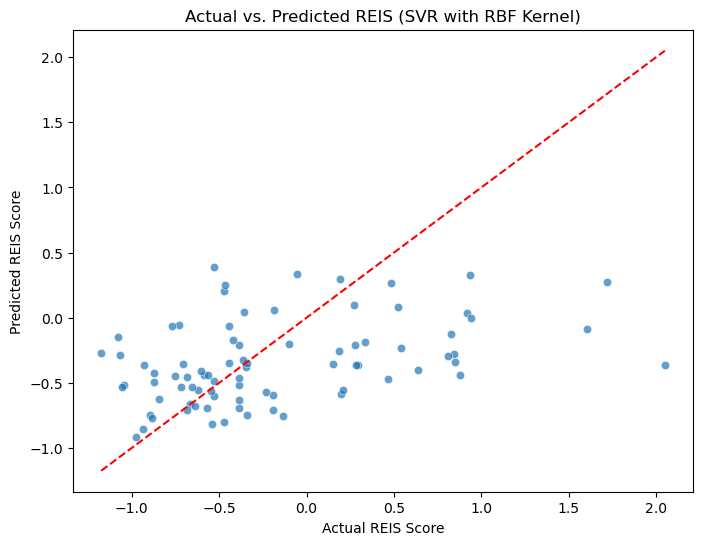

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Actual vs. Predicted REIS
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # y=x line
plt.xlabel("Actual REIS Score")
plt.ylabel("Predicted REIS Score")
plt.title("Actual vs. Predicted REIS (SVR with RBF Kernel)")
plt.show()



##  Random Forests 💔

R² Score: 0.07743336616300822
Mean Absolute Error: 0.4980584729913472
Mean Squared Error: 0.4312760812151287


/var/folders/g1/g05vvb_534vb9bdrljsb7nq80000gn/T/ipykernel_18915/860365925.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




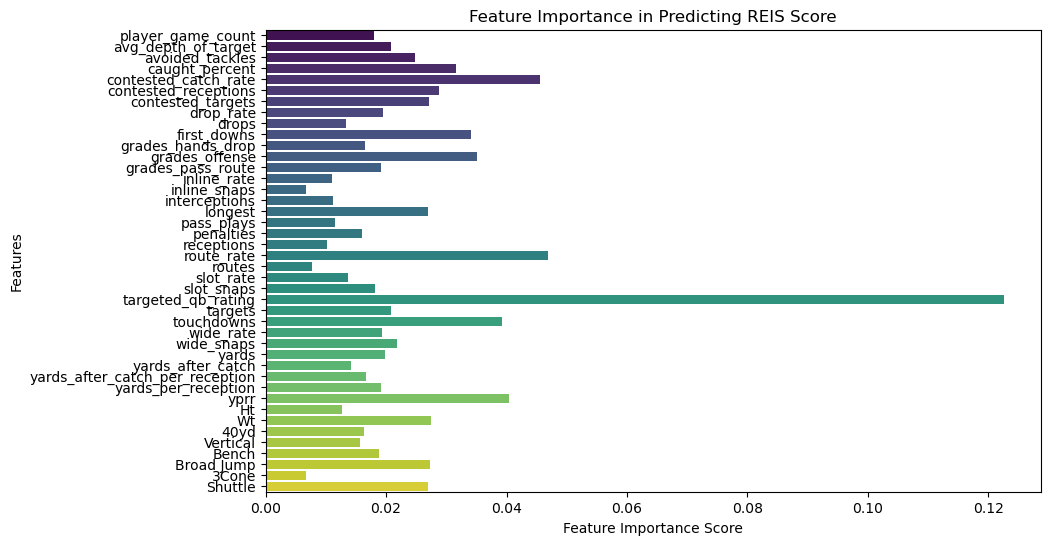

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Initialize model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate performance
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns

# Plot Feature Importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting REIS Score")
plt.show()


## Neural Networks We Are So Cooked Man 💔

In [13]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize X

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build a Sequential model
model = tf.keras.Sequential()

# Input layer (input shape must match the number of features in X)
model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

# First hidden layer
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Second hidden layer
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Output layer
model.add(tf.keras.layers.Dense(1))  # Regression task, so we have a single output node

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



ModuleNotFoundError: No module named 'tensorflow'